In [1]:
import math
import numpy as np
import pandas as pd
import os
import tempfile

from scipy.spatial.distance import pdist, squareform
import scipy.io as sio

import matplotlib.pyplot as plt


# import jtplot submodule from jupyterthemes
#from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
#jtplot.style()

%matplotlib inline

## Steps

    1. Get, for a given time and station, the probability distr of destination
    2. Load travel time between station pairs
    3. Load LSTM predictions
    4. Build FlowsOut (round up/down, set as max(fout,0))
    5. Build FlowsIn (round up/down, use max(fin,0), use travel times)

In [2]:
# 1 distribution by source & time

# load data
orderdf = pd.read_csv('ignored_assets/orders.csv', parse_dates = [6])

# Create map of driver IDs
driver_ids=orderdf['driver_id'].unique()

# create map of core stations
core_stations = orderdf['start_district_hash'].unique()
core_stations.sort()

#Index stuff
orderdf_f=orderdf[(~pd.isnull(orderdf['driver_id'])) & orderdf['dest_district_hash'].isin(core_stations)]
myindex=pd.MultiIndex.from_arrays([orderdf_f['driver_id'],orderdf_f['timestamp']],names=('driver_id','timestamp'))

orderdf2=orderdf_f.set_index(myindex)
orderdf_s=orderdf2.sort_index()

orderdf_s['time_bucket'] = orderdf_s['timestamp'].dt.round('5min')
orderdf_s['pax_arrival_time'] = orderdf_s['timestamp'] + orderdf_s['expected_travel_time'] * pd.Timedelta('1 minute')
orderdf_s['time_bucket_arrival'] = orderdf_s['pax_arrival_time'].dt.round('5min')

# params
stepsize = pd.Timedelta('5 min')
horizon = pd.Timedelta('2 hour')
start = pd.to_datetime('2016-01-21 00:00:00')
end = pd.to_datetime('2016-01-22 00:00:00')

mask = (orderdf_s['time_bucket'] >= start) & (orderdf_s['time_bucket'] < end)

In [6]:
dates = [(start + j*stepsize).time() for j in range(int(horizon / stepsize))]
iterables = [dates, core_stations]
mindex = pd.MultiIndex.from_product(iterables, names=['time_bucket', 'start_district_hash'])
mcolumns = pd.MultiIndex.from_arrays([core_stations], names=['dest_district_hash'])

In [7]:
base = pd.DataFrame(index=mindex, columns=mcolumns).fillna(1./66.)

orderdf_s['time_bucket_s'] = orderdf_s['time_bucket'].map(lambda t: t.time())

pt = pd.pivot_table(orderdf_s[orderdf_s['time_bucket'] < start], index=['time_bucket_s','start_district_hash'], 
               columns=['dest_district_hash'], aggfunc=len, 
               values='order_id', fill_value=0)
pt.index.names = ['time_bucket','start_district_hash']
pt = (base + pt).fillna(0)

prior = pd.pivot_table(orderdf_s[orderdf_s['time_bucket'] < start], index=['start_district_hash'], 
               columns=['dest_district_hash'], aggfunc=len, 
               values='order_id', fill_value=0)

In [8]:
#weight of the prior (based on hours and days of samples)
ndays = 20.
nhours = 24.
w = 1 / (ndays * nhours)

# sum both
count = pt + w*prior

# get posterior
posterior = count.div( count.sum(axis=1), axis = 0).fillna(0)

True


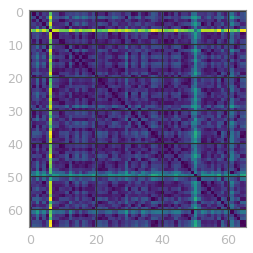

In [6]:
# 2. Load travel time between station pairs

station_locations = pd.read_csv('inferred_locations.csv')
D = np.ceil(squareform(pdist(station_locations[['x','y']].as_matrix())) / 5.)
np.fill_diagonal(D, 1.)
stations = list(station_locations['start_district_hash'])
print stations == list(core_stations)
plt.imshow(D)

travel_times = pd.DataFrame(D)
travel_times.columns = core_stations
travel_times.index = core_stations
travel_times = travel_times * pd.Timedelta('5 min')

In [17]:
# 3. load lstm predictions
tommydf = pd.read_csv('ignored_assets/to_lstm_3b_3f.csv')
tommydf['predicted_at'] = pd.to_datetime(tommydf['predicted_at'])
tommydf['time_bucket'] = pd.to_datetime(tommydf['timestamp'])
tommydf = tommydf.drop('timestamp', axis = 1)

IOError: File ignored_assets/to_lstm_3b_3f.csv does not exist

In [8]:
tommydf.head()

,predicted_at,08232402614a9b48895cc3d0aeb0e9f2,08f5b445ec6b29deba62e6fd8b0325a6,0a5fef95db34383403d11cb6af937309,1afd7afbc81ecc1b13886a569d869e8a,1c60154546102e6525f68cb4f31e0657,1cbfbdd079ef93e74405c53fcfff8567,1ecbb52d73c522f184a6fc53128b1ea1,2301bc920194c95cf0c7486e5675243c,2350be163432e42270d2670cb3c02f80,...,d524868ce69cb9db10fc5af177fb9423,d5cb17978de290c56e84c9cf97e63186,dd8d3b9665536d6e05b29c2648c0e69a,de092beab9305613aca8f79d7d7224e7,f2c8c4bb99e6377d21de71275afd6cd2,f47f35242ed40655814bc086d7514046,f9280c5dab6910ed44e518248048b9fe,fc34648599753c9e74ab238e9a4a07ad,fff4e8465d1e12621bc361276b6217cf,time_bucket
0,2016-01-21,0.016884,0.046968,-0.000392,16.322934,0.372175,1.630101,1.064056,0.806607,0.358025,...,0.203124,-0.000318,3.390428,0.044884,2.579354,0.778331,0.531946,17.396935,0.314306,2016-01-21 00:05:00
1,2016-01-21,0.006394,0.036030,-0.001898,15.817715,0.340996,1.583137,1.031225,0.760231,0.320493,...,0.187096,-0.005286,3.295800,0.031630,2.535262,0.697987,0.478195,17.237746,0.301427,2016-01-21 00:10:00
2,2016-01-21,0.020791,0.047241,0.003056,15.280834,0.346513,1.542412,1.009820,0.763829,0.341281,...,0.195864,0.004550,3.218980,0.053063,2.459888,0.745225,0.506382,16.387141,0.302568,2016-01-21 00:15:00
3,2016-01-21,0.013675,0.037684,0.001553,14.653900,0.320101,1.484988,0.970374,0.717582,0.310774,...,0.179024,0.000755,3.096723,0.041579,2.390271,0.681893,0.461850,15.995901,0.292896,2016-01-21 00:20:00
4,2016-01-21,0.004284,0.025865,-0.000016,14.043024,0.287224,1.420774,0.926735,0.663601,0.272616,...,0.161123,-0.002402,2.983201,0.030674,2.325712,0.598443,0.408193,15.699143,0.277912,2016-01-21 00:25:00


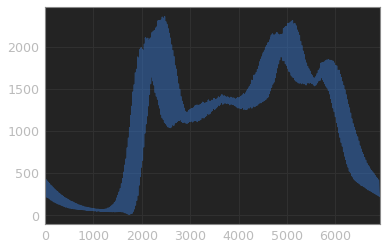

In [11]:
tommydf[core_stations].sum(axis=1).plot(alpha=0.5)

In [12]:
wrong_vals = tommydf['time_bucket'][tommydf['time_bucket'] >= pd.to_datetime('2016-01-22T00:00:00.000000000')].unique()

In [13]:
corrected_vals = [pd.to_datetime('2016-01-22T00:00:00.000000000') + j*stepsize for j in range(int(horizon / stepsize))]

In [14]:
for i in range(len(wrong_vals)):
    tommydf['time_bucket'][tommydf['time_bucket'] == wrong_vals[i]] = corrected_vals[i]

/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
# 4. build flows out
# flows out is simply at each time step the travel demand!
nsteps = int(pd.Timedelta('1 day') / stepsize)
flowsout = np.zeros((nsteps,), dtype=np.object)
columns = core_stations
for i in range(nsteps):
    begin = start + i*stepsize
    pred = tommydf[tommydf['predicted_at'] == begin][core_stations].round()
    pred[pred < 0] = 0
    base = np.zeros((pred.shape[0] + 1, pred.shape[1]))
    base[1:,:] += pred.as_matrix()
    flowsout[i] = base

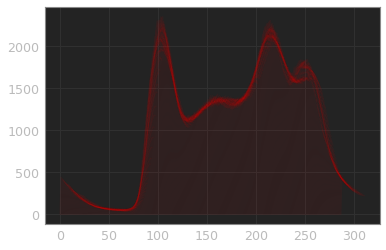

In [16]:
totsteps = 24 * 12
for i,pred in enumerate(flowsout):
    plt.plot(range(i,i+25), pred.sum(axis=1), color='red', alpha = 0.05)

In [17]:
# 5. get flowsin

# 5.1 unstack
def reshape_table(df, prediction_time):
    df_pred = df[df['predicted_at'] == prediction_time]
    df_pred = df_pred.set_index('time_bucket')[core_stations].stack()#.reset_index()
    #df_pred.columns = ['time_bucket', 'start_district_hash', 'demand']
    #df_pred = pd.DataFrame(df_pred)
    df_pred.index.names = ['time_bucket','start_district_hash']
    df_pred.columns = ['demand']
    return df_pred

# 5.2 multiply by the posterior
def get_flows(series, post):
    dfs = []
    for d in series.index.levels[0]:
        # TODO: FIX THE FILLNA, HACKY HACK
        pred = post.loc[d.time()].multiply(series.loc[d], axis='index').fillna(0)
        pred[pred < 0] = 0
        dfs.append(pred)
    df = pd.concat(dfs, keys=series.index.levels[0])
    return df.stack().reset_index(name='demand')

# 5.3 get arrival times
def get_arrival_time(df):
    return travel_times.lookup(df['start_district_hash'], df['dest_district_hash']) + df['time_bucket']

# 5.4 rearrange into flowsin
def get_flows_in(df, begin, end, stepsize, horizon):
    # where begin and end are datetimes
    index = [begin + j*stepsize for j in range(int(horizon / stepsize))]
    base = pd.DataFrame(
        np.zeros((len(index),len(columns)),dtype=np.float64),
        index=index,
        columns = core_stations
    )
    pred = pd.pivot_table(df, index=['arrival_time_bucket'], columns=['dest_district_hash'], 
               aggfunc=np.sum, values='demand', fill_value=0)[core_stations]
    pred = (base + pred).fillna(0).as_matrix()
    return pred

In [18]:
start

Timestamp('2016-01-21 00:00:00')

In [19]:
rt = reshape_table(tommydf, start)

In [20]:
od_pred = get_flows(rt, posterior)

In [21]:
od_pred['arrival_time_bucket'] = get_arrival_time(od_pred)

In [22]:
od_pred.head()

,time_bucket,start_district_hash,dest_district_hash,demand,arrival_time_bucket
0,2016-01-21 00:05:00,08232402614a9b48895cc3d0aeb0e9f2,08232402614a9b48895cc3d0aeb0e9f2,0.001090,2016-01-21 00:10:00
1,2016-01-21 00:05:00,08232402614a9b48895cc3d0aeb0e9f2,08f5b445ec6b29deba62e6fd8b0325a6,0.000031,2016-01-21 01:00:00
2,2016-01-21 00:05:00,08232402614a9b48895cc3d0aeb0e9f2,0a5fef95db34383403d11cb6af937309,0.000031,2016-01-21 01:20:00
3,2016-01-21 00:05:00,08232402614a9b48895cc3d0aeb0e9f2,1afd7afbc81ecc1b13886a569d869e8a,0.000048,2016-01-21 00:50:00
4,2016-01-21 00:05:00,08232402614a9b48895cc3d0aeb0e9f2,1c60154546102e6525f68cb4f31e0657,0.000031,2016-01-21 00:50:00


In [23]:
get_flows_in(od_pred, start, start+horizon, stepsize, horizon).shape

(69, 66)

In [24]:
flowsin = np.zeros((nsteps,), dtype=np.object)
columns = core_stations
for i in range(nsteps):
    begin = start + i*stepsize
    end = begin + horizon
    # 5.1
    rt = reshape_table(tommydf, begin)
    # 5.2
    od_pred = get_flows(rt, posterior)
    # 5.3
    od_pred['arrival_time_bucket'] = get_arrival_time(od_pred)
    # 5.4 
    fin = get_flows_in(od_pred, begin, end, stepsize, horizon)
    # eventually we should not have to rond
    flowsin[i] = fin.round()

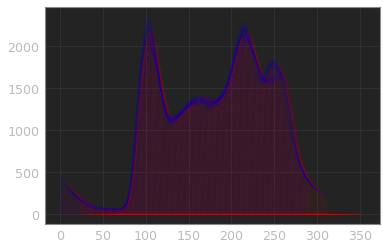

In [25]:
totsteps = 24 * 12
for i,pred in enumerate(flowsin):
    plt.plot(range(i,i+pred.shape[0]), pred.sum(axis=1), color='red', alpha = 0.05)
    
totsteps = 24 * 12
for i,pred in enumerate(flowsout):
    plt.plot(range(i,i+pred.shape[0]), pred.sum(axis=1), color='blue', alpha = 0.05)

In [26]:
predictions  ={
        'FlowsIn': flowsin,
        'FlowsOut': flowsout
    }

In [27]:
sio.savemat('lstm_predictions.mat',predictions)

In [28]:
perfpreds = sio.loadmat('perfect_predictions.mat')

In [29]:
pflowsin = perfpreds['FlowsIn']
pflowsout = perfpreds['FlowsOut']

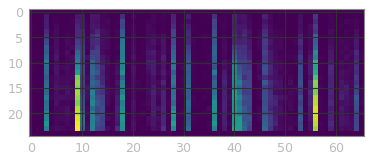

In [31]:
plt.imshow(pflowsout[0][80])

In [32]:
np.argmax(pflowsout[0][80][-2])

9

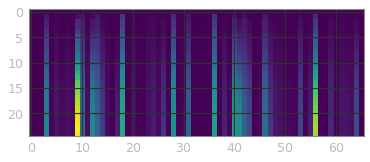

In [33]:
plt.imshow(flowsout[80])

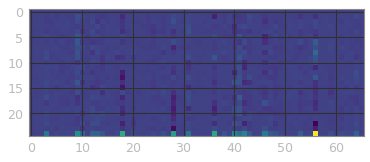

In [34]:
plt.imshow(flowsout[144] - pflowsout[0][144])

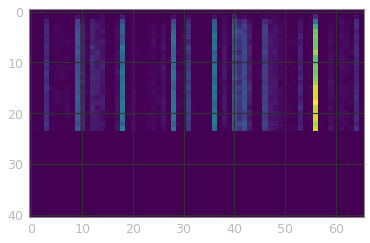

In [35]:
plt.imshow(pflowsin[0][144])

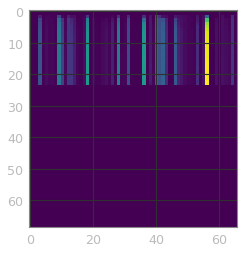

In [36]:
plt.imshow(flowsin[144])

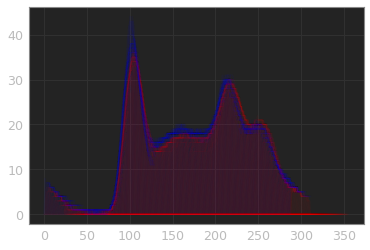

In [37]:
totsteps = 24 * 12
for i,pred in enumerate(flowsin):
    plt.plot(range(i,i+pred.shape[0]), pred[:,14], color='red', alpha = 0.05)
    
totsteps = 24 * 12
for i,pred in enumerate(flowsout):
    plt.plot(range(i,i+pred.shape[0]), pred[:,14], color='blue', alpha = 0.05)

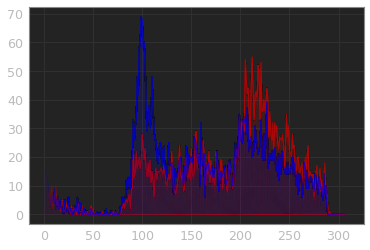

In [38]:
totsteps = 24 * 12
for i,pred in enumerate(pflowsin[0]):
    plt.plot(range(i,i+pred.shape[0]), pred[:,14], color='red', alpha = 0.05)
    
totsteps = 24 * 12
for i,pred in enumerate(pflowsout[0]):
    plt.plot(range(i,i+pred.shape[0]), pred[:,14], color='blue', alpha = 0.05)

In [ ]:

for s,shash in enumerate(core_stations):
    totsteps = 24 * 12
    for i,pred in enumerate(flowsin):
        diffp = flowsin[i][:,s][:24] #- flowsout[i][:,s][:24]
        mdiff = np.argmax(np.abs(diffp))
        plt.plot(range(i,i+diffp.shape[0]), diffp, color='red', alpha = 0.05, label="Predicted");

    for i,pred in enumerate(flowsin):
        diffr = pflowsin[0][i][:,s][:24] #- pflowsout[0][i][:,s][:24]
        plt.plot(range(i,i+diffr.shape[0]), diffr, color='blue', alpha = 0.05, label="Actual");

    plt.figure(figsize=(20,10));
    plt.title('Station ' + str(s) + ', ' + shash)

In [ ]:
a = np.array([])
b = np.array([])
for s,shash in enumerate(core_stations):
    totsteps = 24 * 12
    for i,pred in enumerate(flowsin):
        a = np.concatenate((a,flowsout[i][:,s][:5]))

    for i,pred in enumerate(flowsin):
        b = np.concatenate((b,pflowsout[0][i][:,s][:5]))

plt.figure(figsize=(20,10));
plt.scatter(b,a)
plt.plot(b,b, color='red', alpha =0.5)
plt.plot(b,b*0.8, color='red', alpha =0.2)
plt.plot(b,b*1.2, color='red', alpha =0.2)

In [ ]:
plt.figure(figsize=(20,10));
plt.scatter(b,a-b)
plt.plot(b,b-b, color='red', alpha =0.5)
plt.plot(b,b*0.8-b, color='red', alpha =0.2)
plt.plot(b,b*1.2-b, color='red', alpha =0.2)

## TOD Predictions

### Attempt 1

In [360]:
predictor = np.zeros((nsteps,), dtype=np.object)

for i in range(nsteps):
    begin = start + i*stepsize
    end = begin + horizon
    index = [begin + (j+1)*stepsize for j in range(int(horizon / stepsize))]
    predictor[i] = np.zeros((len(index)+1,), dtype=np.object)
    base = pd.DataFrame(
            np.zeros((len(core_stations),len(core_stations)),dtype=np.float64),
            index=core_stations,
            columns = core_stations
        )
    predictor[i][0] = base.as_matrix()
    for j,t in enumerate(index):
        interim = tommydf[(tommydf['predicted_at'] == begin) & (tommydf['time_bucket'] == t)][core_stations].T
        interim.columns = ['demand']
        interim = posterior.loc[t.time()].multiply(interim['demand'], axis='index').fillna(0)
        interim[interim < 0] = 0
        predictor[i][j+1] = (base + interim).fillna(0).as_matrix().round()

In [361]:
tod_predictions  ={
        'predictor': predictor
    }

In [362]:
sio.savemat('ignored_assets/tod_predictions_tommylstm.mat',tod_predictions)

### Empty Predictor

In [363]:
empty_predictor = np.zeros((nsteps,), dtype=np.object)

for i in range(nsteps):
    begin = start + i*stepsize
    end = begin + horizon
    index = [begin + (j+1)*stepsize for j in range(int(horizon / stepsize))]
    empty_predictor[i] = np.zeros((len(index)+1,), dtype=np.object)
    base = pd.DataFrame(
            np.zeros((len(core_stations),len(core_stations)),dtype=np.float64),
            index=core_stations,
            columns = core_stations
        )
    empty_predictor[i][0] = base.as_matrix()
    for j,t in enumerate(index):
        empty_predictor[i][j+1] = base.as_matrix()

In [364]:
tod_predictions_empty  ={
        'predictor': empty_predictor
    }

In [365]:
sio.savemat('ignored_assets/tod_predictions_empty.mat',tod_predictions_empty)

### Attempt 2

In [9]:
#weight of the prior (based on hours and days of samples)
ndays = 20.
nhours = 24.
w = 1e-6

# sum both
count = pt + w*prior

# get posterior
posterior2 = count.div( count.sum(axis=1), axis = 0).fillna(0)

In [58]:
predictor = np.zeros((nsteps,), dtype=np.object)

for i in range(nsteps):
    begin = start + i*stepsize
    end = begin + horizon
    index = [begin + (j+1)*stepsize for j in range(int(horizon / stepsize))]
    predictor[i] = np.zeros((len(index)+1,), dtype=np.object)
    base = pd.DataFrame(
            np.zeros((len(core_stations),len(core_stations)),dtype=np.float64),
            index=core_stations,
            columns = core_stations
        )
    predictor[i][0] = base.as_matrix()
    for j,t in enumerate(index):
        interim = tommydf[(tommydf['predicted_at'] == begin) & (tommydf['time_bucket'] == t)][core_stations].T
        interim.columns = ['demand']
        interim = posterior2.loc[t.time()].multiply(interim['demand'], axis='index').fillna(0)
        interim[interim < 0] = 0
        predictor[i][j+1] = (base + interim).fillna(0).as_matrix().round()

In [59]:
tod_predictions_np  ={
        'predictor': predictor
    }

In [60]:
sio.savemat('ignored_assets/tod_predictions_tommylstm_np.mat',tod_predictions_np)

### Attempt 3

In [4]:
# 3. load lstm predictions
newdf = pd.read_csv('ignored_assets/new_lstm_to_pred.csv')
newdf['predicted_at'] = pd.to_datetime(newdf['predicted_at'])
newdf['time_bucket'] = pd.to_datetime(newdf['timestamp'])
newdf = newdf.drop('timestamp', axis = 1)

In [11]:
nsteps = int(pd.Timedelta('1 day') / stepsize)

In [12]:
predictor = np.zeros((nsteps,), dtype=np.object)

for i in range(nsteps):
    begin = start + i*stepsize
    end = begin + horizon
    index = [begin + (j+1)*stepsize for j in range(int(horizon / stepsize))]
    predictor[i] = np.zeros((len(index)+1,), dtype=np.object)
    base = pd.DataFrame(
            np.zeros((len(core_stations),len(core_stations)),dtype=np.float64),
            index=core_stations,
            columns = core_stations
        )
    predictor[i][0] = base.as_matrix()
    for j,t in enumerate(index):
        interim = newdf[(newdf['predicted_at'] == begin) & (newdf['time_bucket'] == t)][core_stations].T
        interim.columns = ['demand']
        interim = posterior.loc[t.time()].multiply(interim['demand'], axis='index').fillna(0)
        interim[interim < 0] = 0
        predictor[i][j+1] = (base + interim).fillna(0).as_matrix().round()

In [14]:
tod_predictions_nl  ={
        'predictor': predictor
    }

sio.savemat('ignored_assets/tod_predictions_seaslstm_np.mat',tod_predictions_nl)

In [24]:
nsteps

288

In [27]:
len(predictor)

288